# Import Detectron2 with Custom COCO Datasets

In [1]:
import detectron2
from detectron2.utils.logger import setup_logger
# import some common libraries
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import gdown
import torch
import math

# import some common detectron2 utilities
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2 import model_zoo
from detectron2.data.datasets import register_coco_instances

## Register your own data set in coco format configs

In [2]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("wamv_train",)
cfg.DATASETS.TEST = ("wamv_val", )
cfg.DATALOADER.NUM_WORKERS = 0 #Single thread
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 5  # datasets classes
cfg.SOLVER.IMS_PER_BATCH = 4 #Batch size
ITERS_IN_ONE_EPOCH = 610 #dataset_imgs/batch_size
cfg.SOLVER.MAX_ITER = (ITERS_IN_ONE_EPOCH * 50) # ITERS
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MOMENTUM = 0.9
cfg.SOLVER.WEIGHT_DECAY = 0.0001
cfg.SOLVER.GAMMA = 0.1
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.SOLVER.WARMUP_FACTOR = 1.0 / 1000
cfg.SOLVER.WARMUP_ITERS = 1000
cfg.SOLVER.WARMUP_METHOD = "linear"
cfg.SOLVER.CHECKPOINT_PERIOD = ITERS_IN_ONE_EPOCH #Save training model interval
cfg.MODEL.WEIGHTS = "wamv_boats_split/model_final.pth"
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.8   # set the testing threshold for this model
#register_coco_instances('wamv_val', {}, 
#                        '/home/arg/Mask-RCNN-Detectron2/datasets/split_dir/val.json', 
#                       '/home/arg/Mask-RCNN-Detectron2/datasets/split_dir/val')
cfg.DATASETS.TEST = ("wamv_val", )
subt_metadata = MetadataCatalog.get("wamv_val")
dataset_dicts = DatasetCatalog.get("wamv_val")

KeyError: "Dataset 'wamv_val' is not registered! Available datasets are: coco_2014_train, coco_2014_val, coco_2014_minival, coco_2014_minival_100, coco_2014_valminusminival, coco_2017_train, coco_2017_val, coco_2017_test, coco_2017_test-dev, coco_2017_val_100, keypoints_coco_2014_train, keypoints_coco_2014_val, keypoints_coco_2014_minival, keypoints_coco_2014_valminusminival, keypoints_coco_2014_minival_100, keypoints_coco_2017_train, keypoints_coco_2017_val, keypoints_coco_2017_val_100, coco_2017_train_panoptic_separated, coco_2017_train_panoptic_stuffonly, coco_2017_val_panoptic_separated, coco_2017_val_panoptic_stuffonly, coco_2017_val_100_panoptic_separated, coco_2017_val_100_panoptic_stuffonly, lvis_v1_train, lvis_v1_val, lvis_v1_test_dev, lvis_v1_test_challenge, lvis_v0.5_train, lvis_v0.5_val, lvis_v0.5_val_rand_100, lvis_v0.5_test, lvis_v0.5_train_cocofied, lvis_v0.5_val_cocofied, cityscapes_fine_instance_seg_train, cityscapes_fine_sem_seg_train, cityscapes_fine_instance_seg_val, cityscapes_fine_sem_seg_val, cityscapes_fine_instance_seg_test, cityscapes_fine_sem_seg_test, voc_2007_trainval, voc_2007_train, voc_2007_val, voc_2007_test, voc_2012_trainval, voc_2012_train, voc_2012_val"

## Visualize dataset - make sure the data is loaded without problems

To verify the data loading is correct, let's visualize the annotations of randomly selected samples in the dataset.

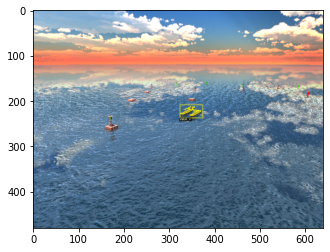

In [3]:
import random

for d in random.sample(dataset_dicts, 1):
    #print(d)
    img = cv2.imread(d["file_name"])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    visualizer = Visualizer(img[:, :, ::-1], metadata=subt_metadata, scale=1)
    vis = visualizer.draw_dataset_dict(d)
    plt.imshow(vis.get_image()[:, :, ::-1], cmap='nipy_spectral')
    #cv2.waitKey(0)

## Make a prediction

In [4]:
models_name = "model_final.pth"
if os.path.isfile("split/" + models_name):
    print("Finished downloading models.") 

Finished downloading models.


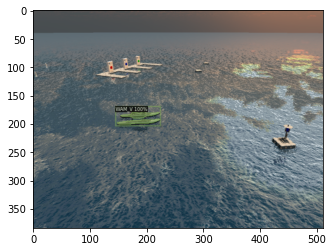

In [33]:
from detectron2.utils.visualizer import ColorMode
import random

predictor = DefaultPredictor(cfg)

for d in random.sample(dataset_dicts, 1):    
    im = cv2.imread(d["file_name"])
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    #print(im)
    outputs = predictor(im)
    #print(outputs)
    v = Visualizer(im[:, :, ::-1],
                   metadata=subt_metadata, 
                   scale=0.8
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.imshow(v.get_image()[:, :, ::-1], cmap='nipy_spectral')